# Logistic Regression Predictor

This script utilizes a logistic regression to predict the probability a zip code would become gentrified in a given year

In [ ]:
import pandas as pd

# Load income classification data and select relevant columns
df_income = pd.read_csv('../data/low_income_classification_by_year.csv')
df_income_subset = df_income[['zip_code', 'msa_name', 'year', 'income']]

# Load college education classification data and select relevant columns
df_college = pd.read_csv('../data/college_educated_classification_gentrified_overtime.csv')
df_college_subset = df_college[['zip_code', 'msa_name', 'year', 'per_college_educated']]

# Load rent data for the year 2011 and select relevant columns
df_rent_2011 = pd.read_csv('../data/rent_2011.csv')
df_rent_2011 = df_rent_2011[['zip_code', 'msa_name', 'year', 'median_contract_rent']]

# Load rent data for years 2012-2023 and select relevant columns
df_rent_later = pd.read_csv('../data/rent_2012_2023.csv')
df_rent_later = df_rent_later[['zip_code', 'msa_name', 'year', 'median_contract_rent']]

# Combine rent data from 2011 and 2012-2023 into a single dataframe
df_rent = pd.concat([df_rent_later, df_rent_2011], ignore_index=True)

# Drop any columns in rent dataframe that contain missing values
df_rent = df_rent.dropna(axis=1, how='any')

# Merge income and college education data on ZIP code, MSA, and year using left join
df = pd.merge(df_income_subset, df_college_subset, on=['zip_code', 'msa_name', 'year'], how='left')

# Merge the combined income/college dataframe with rent data on ZIP code, MSA, and year using left join
df = pd.merge(df, df_rent, on=['zip_code', 'msa_name', 'year'], how='left')

# Ensure ZIP codes are strings padded with leading zeros to 5 digits for consistency
df['zip_code'] = df['zip_code'].astype(str).str.zfill(5)

# Drop any rows with missing values in any columns to keep only complete data
df = df.dropna()

# Display the final cleaned and merged dataframe
df


,zip_code,msa_name,year,income,per_college_educated,median_contract_rent
0,00602,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,15106.0,20.100000,2869.0
1,00603,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,15079.0,21.000000,5897.0
2,00610,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,16923.0,14.700000,2055.0
3,00631,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,11651.0,14.700000,272.0
4,00662,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,14735.0,17.200000,5257.0
...,...,...,...,...,...,...
199409,99705,"Fairbanks, AK MSA",2023,96966.0,23.235542,1702.0
199410,99709,"Fairbanks, AK MSA",2023,82991.0,39.784946,4452.0
199411,99712,"Fairbanks, AK MSA",2023,103494.0,34.573561,683.0
199412,99714,"Fairbanks, AK MSA",2023,71042.0,24.044734,38.0


In [195]:
# start_year = 2012
# end_year = 2018

# track = []
# for year in range(start_year, end_year):
#     end = start_year + 5
df_start = df[df['year'] == 2012].copy()
df_end = df[df['year'] == 2022].copy()

df_start = df_start.rename(columns={
    'income': 'income_2012',
    'per_college_educated': 'college_2012',
    'median_contract_rent': 'rent_2012'
})

df_end = df_end.rename(columns={
    'income': 'income_2022',
    'per_college_educated': 'college_2022',
    'median_contract_rent': 'rent_2022'
})

df_merged = pd.merge(df_start, df_end, on=['zip_code', 'msa_name'], how='inner')

df_merged['income_change'] = df_merged['income_2022'] - df_merged['income_2012']
df_merged['rent_change'] = df_merged['rent_2022'] - df_merged['rent_2012']
df_merged['college_change'] = df_merged['college_2022'] - df_merged['college_2012']

msa_medians = df_merged.groupby('msa_name')[['income_change', 'rent_change', 'college_change']].median().reset_index()
msa_medians = msa_medians.rename(columns={
    'income_change': 'msa_income_median',
    'rent_change': 'msa_rent_median',
    'college_change': 'msa_college_median'
})

df_final = pd.merge(df_merged, msa_medians, on='msa_name', how='left')

df_final['gentrified'] = (
    (df_final['income_change'] > df_final['msa_income_median']) &
    (df_final['rent_change'] > df_final['msa_rent_median']) &
    (df_final['college_change'] > df_final['msa_college_median'])
).astype(int)

# track.append(df_next)



# df_final = pd.concat(track)

# df_final = df_final.reset_index()

In [ ]:
# Calculate change in income from 2012 to 2022 for each ZIP code/MSA
df_merged['income_change'] = df_merged['income_2022'] - df_merged['income_2012']

# Calculate change in median contract rent from 2012 to 2022 for each ZIP code/MSA
df_merged['rent_change'] = df_merged['rent_2022'] - df_merged['rent_2012']

# Calculate change in percentage of college-educated residents from 2012 to 2022
df_merged['college_change'] = df_merged['college_2022'] - df_merged['college_2012']

# Compute the median changes for income, rent, and college education at the MSA (metropolitan statistical area) level
# Group by 'msa_name' and calculate median for each change metric
msa_medians = df_merged.groupby('msa_name')[['income_change', 'rent_change', 'college_change']].median().reset_index()

# Rename the columns to indicate these are median values for each MSA
msa_medians = msa_medians.rename(columns={
    'income_change': 'msa_income_median',
    'rent_change': 'msa_rent_median',
    'college_change': 'msa_college_median'
})

# Merge the MSA-level median change values back into the original dataframe
# This allows comparison of each ZIP code's changes to their MSA median benchmarks
df_final = pd.merge(df_merged, msa_medians, on='msa_name', how='left')


In [ ]:
# Create a new binary column 'gentrified' to classify if an area (ZIP code) is gentrified
# Criteria for gentrification:
#  - Income change is greater than the MSA median income change
#  - Rent change is greater than the MSA median rent change
#  - College-educated percentage change is greater than the MSA median college education change
# All three conditions must be met simultaneously for the area to be classified as gentrified

df_final['gentrified'] = (
    (df_final['income_change'] > df_final['msa_income_median']) &
    (df_final['rent_change'] > df_final['msa_rent_median']) &
    (df_final['college_change'] > df_final['msa_college_median'])
).astype(int)  # Convert boolean True/False to integer 1/0 for easier analysis

# Display the updated dataframe with the new 'gentrified' classification column
df_final


,zip_code,msa_name,year_x,income_2012,college_2012,rent_2012,year_y,income_2022,college_2022,rent_2022,income_change,rent_change,college_change,msa_income_median,msa_rent_median,msa_college_median,gentrified
0,00602,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,15106.0,20.1,2869.0,2022,20260.0,20.575270,3147.0,5154.0,278.0,0.475270,5673.0,314.0,3.181886,0
1,00603,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,15079.0,21.0,5897.0,2022,17703.0,22.823391,8366.0,2624.0,2469.0,1.823391,5673.0,314.0,3.181886,0
2,00610,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,16923.0,14.7,2055.0,2022,22796.0,21.915303,2389.0,5873.0,334.0,7.215303,5673.0,314.0,3.181886,1
3,00631,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,11651.0,14.7,272.0,2022,15658.0,28.327645,202.0,4007.0,-70.0,13.627645,5673.0,314.0,3.181886,0
4,00662,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,14735.0,17.2,5257.0,2022,20283.0,24.169736,5551.0,5548.0,294.0,6.969736,5673.0,314.0,3.181886,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16353,99705,"Fairbanks, AK MSA",2012,80606.0,18.1,1955.0,2022,88788.0,23.022390,1742.0,8182.0,-213.0,4.922390,8789.5,-12.0,-1.967382,0
16354,99709,"Fairbanks, AK MSA",2012,72900.0,39.6,4365.0,2022,80467.0,40.215682,4455.0,7567.0,90.0,0.615682,8789.5,-12.0,-1.967382,0
16355,99712,"Fairbanks, AK MSA",2012,88716.0,34.3,818.0,2022,105787.0,31.573135,750.0,17071.0,-68.0,-2.726865,8789.5,-12.0,-1.967382,0
16356,99714,"Fairbanks, AK MSA",2012,69219.0,34.7,119.0,2022,66250.0,29.319955,45.0,-2969.0,-74.0,-5.380045,8789.5,-12.0,-1.967382,0


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
import numpy as np

# Initialize SMOTE for handling class imbalance by oversampling the minority class
smote = SMOTE()

# Select data only for the Boston-Cambridge-Quincy MSA for model training and evaluation
test_df = df_final[df_final['msa_name'] == "Boston-Cambridge-Quincy, MA-NH MSA"]

# Select features (income, rent, college) from 2012 data to predict gentrification
X = test_df[['income_2012', 'rent_2012', 'college_2012']]

# Rename columns for clarity and simplicity
X.columns = ['income', 'rent', 'college']

# Target variable: binary indicator if the area was gentrified
y = test_df['gentrified']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Apply SMOTE on the training data to synthetically balance classes by oversampling the minority class
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize a standard scaler for feature normalization (mean=0, std=1)
scaler = StandardScaler()

# Define logistic regression model with L2 regularization, balanced class weights, and max 1000 iterations
model_b = LogisticRegression(penalty='l2', C=1, class_weight='balanced', max_iter=1000)

# Create a pipeline to chain scaling and modeling steps for cleaner workflow
pipeline_b = make_pipeline(scaler, model_b)

# Train the model pipeline on the resampled training data
pipeline_b.fit(X_train_resampled, y_train_resampled)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, class_weight='balanced',
                                    max_iter=1000))])

In [ ]:
# Select data for the starting year 2013 and create a copy to avoid modifying original DataFrame
df_start_t = df[df['year'] == 2013].copy()

# Select data for the ending year 2023 and create a copy
df_end_t = df[df['year'] == 2023].copy()

# Rename columns in the 2013 DataFrame to indicate the year, for clarity after merging
df_start_t = df_start_t.rename(columns={
    'income': 'income_2013',
    'per_college_educated': 'college_2013',
    'median_contract_rent': 'rent_2013'
})

# Similarly, rename columns in the 2023 DataFrame to indicate the year
df_end_t = df_end_t.rename(columns={
    'income': 'income_2023',
    'per_college_educated': 'college_2023',
    'median_contract_rent': 'rent_2023'
})

# Merge the two DataFrames on 'zip_code' and 'msa_name' to align data from 2013 and 2023 side-by-side
# Using inner join to keep only zip codes present in both years
df_merged_t = pd.merge(df_start_t, df_end_t, on=['zip_code', 'msa_name'], how='inner')

# Display the merged DataFrame with features from both years
df_merged_t


,zip_code,msa_name,year_x,income_2013,college_2013,rent_2013,year_y,income_2023,college_2023,rent_2023
0,00602,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15663.0,20.1,2880.0,2023,21702.0,22.547348,3103.0
1,00603,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15485.0,20.9,6168.0,2023,19243.0,23.917408,8389.0
2,00610,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,16707.0,13.8,2202.0,2023,23732.0,23.986928,2423.0
3,00631,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,11596.0,15.6,292.0,2023,18295.0,30.172414,182.0
4,00662,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15600.0,18.0,5469.0,2023,20673.0,23.656758,5004.0
...,...,...,...,...,...,...,...,...,...,...
16313,99705,"Fairbanks, AK MSA",2013,76156.0,18.4,2192.0,2023,96966.0,23.235542,1702.0
16314,99709,"Fairbanks, AK MSA",2013,71287.0,39.5,4715.0,2023,82991.0,39.784946,4452.0
16315,99712,"Fairbanks, AK MSA",2013,85085.0,35.3,737.0,2023,103494.0,34.573561,683.0
16316,99714,"Fairbanks, AK MSA",2013,76250.0,35.3,89.0,2023,71042.0,24.044734,38.0


In [ ]:
# Calculate the change in income from 2013 to 2023 for each zip code/MSA
df_merged_t['income_change'] = df_merged_t['income_2023'] - df_merged_t['income_2013']

# Calculate the change in median contract rent from 2013 to 2023
df_merged_t['rent_change'] = df_merged_t['rent_2023'] - df_merged_t['rent_2013']

# Calculate the change in percentage of college-educated population from 2013 to 2023
df_merged_t['college_change'] = df_merged_t['college_2023'] - df_merged_t['college_2013']

# Group the data by metropolitan statistical area (MSA) to find median changes within each MSA
msa_medians_t = df_merged_t.groupby('msa_name')[['income_change', 'rent_change', 'college_change']].median().reset_index()

# Rename columns to clarify these are median changes at the MSA level
msa_medians_t = msa_medians_t.rename(columns={
    'income_change': 'msa_income_median',
    'rent_change': 'msa_rent_median',
    'college_change': 'msa_college_median'
})

# Merge the median MSA-level change values back into the main DataFrame for each zip code/MSA
# This will allow comparison of each zip code's changes against the median changes in its MSA
df_test_t = pd.merge(df_merged_t, msa_medians_t, on='msa_name', how='left')


In [ ]:
# Create a new binary column 'gentrified' indicating if a zip code has gentrified
# A zip code is considered gentrified if its changes in income, rent, and college education
# all exceed the median changes for its respective MSA (metropolitan statistical area)

df_test_t['gentrified'] = (
    (df_test_t['income_change'] > df_test_t['msa_income_median']) &   # Income change greater than MSA median
    (df_test_t['rent_change'] > df_test_t['msa_rent_median']) &       # Rent change greater than MSA median
    (df_test_t['college_change'] > df_test_t['msa_college_median'])   # College-educated change greater than MSA median
).astype(int)  # Convert boolean True/False to integer 1/0

# Display the updated dataframe with the new 'gentrified' column
df_test_t


,zip_code,msa_name,year_x,income_2013,college_2013,rent_2013,year_y,income_2023,college_2023,rent_2023,income_change,rent_change,college_change,msa_income_median,msa_rent_median,msa_college_median,gentrified
0,00602,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15663.0,20.1,2880.0,2023,21702.0,22.547348,3103.0,6039.0,223.0,2.447348,6286.0,222.0,3.828907,0
1,00603,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15485.0,20.9,6168.0,2023,19243.0,23.917408,8389.0,3758.0,2221.0,3.017408,6286.0,222.0,3.828907,0
2,00610,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,16707.0,13.8,2202.0,2023,23732.0,23.986928,2423.0,7025.0,221.0,10.186928,6286.0,222.0,3.828907,0
3,00631,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,11596.0,15.6,292.0,2023,18295.0,30.172414,182.0,6699.0,-110.0,14.572414,6286.0,222.0,3.828907,0
4,00662,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15600.0,18.0,5469.0,2023,20673.0,23.656758,5004.0,5073.0,-465.0,5.656758,6286.0,222.0,3.828907,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16313,99705,"Fairbanks, AK MSA",2013,76156.0,18.4,2192.0,2023,96966.0,23.235542,1702.0,20810.0,-490.0,4.835542,13570.0,-52.5,-4.061560,0
16314,99709,"Fairbanks, AK MSA",2013,71287.0,39.5,4715.0,2023,82991.0,39.784946,4452.0,11704.0,-263.0,0.284946,13570.0,-52.5,-4.061560,0
16315,99712,"Fairbanks, AK MSA",2013,85085.0,35.3,737.0,2023,103494.0,34.573561,683.0,18409.0,-54.0,-0.726439,13570.0,-52.5,-4.061560,0
16316,99714,"Fairbanks, AK MSA",2013,76250.0,35.3,89.0,2023,71042.0,24.044734,38.0,-5208.0,-51.0,-11.255266,13570.0,-52.5,-4.061560,0


In [ ]:
# Filter data to include only ZIP codes in the Boston-Cambridge-Quincy MSA
test_df_t = df_test_t[df_test_t['msa_name'] == "Boston-Cambridge-Quincy, MA-NH MSA"]

# Prepare feature matrix and target variable
X_eval = test_df_t[['income_2013', 'rent_2013', 'college_2013']]
X_eval.columns = ['income', 'rent', 'college']
y_eval = test_df_t['gentrified']

# Scale features using the same scaler from training
X_eval_scaled = scaler.transform(X_eval)

# Predict gentrification probabilities
y_probs = model_b.predict_proba(X_eval_scaled)[:, 1]

# Evaluate model performance
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, roc_curve

ll = -log_loss(y_eval, y_probs, normalize=False)  # Negative log loss as log-likelihood approximation
fpr, tpr, thresholds = roc_curve(y_eval, y_probs)
auc = roc_auc_score(y_eval, y_probs)
acc = accuracy_score(y_eval, model_b.predict(X_eval_scaled))

print(f'Log Likelihood (approx): {ll}')
print(f'AUC: {auc:.3f}')
print(f'Accuracy: {acc:.3f}')


Log Likelihood (approx): -219.78937757740755
AUC: 0.574
Accuracy: 0.381


In [ ]:
import pandas as pd

# Load the forecasted data file (includes multiple years)
df_import = pd.read_csv('../data/forecasted_data_2035.csv')

# Extract data for the year 2021
df_other = df_import[df_import['year'] == 2021]

# Keep only relevant columns and rename them for clarity
df_other = df_other[['zip_code','forecasted_income', 'forecasted_median_contract_rent', 'forecasted_per_college_educated']]
df_other.columns = ['zip_code', 'income_2021', 'rent_2021', 'college_2021']

# Ensure ZIP codes are 5-digit strings with leading zeros
df_other['zip_code'] = df_other['zip_code'].astype(str).str.zfill(5)

# Extract data for the year 2025
df_import = df_import[df_import['year'] == 2025]

# Drop the 'year' column since it's no longer needed
df_import = df_import.drop(columns='year')

# Keep and rename relevant columns for 2025
df_import = df_import[['zip_code', 'forecasted_income', 'forecasted_median_contract_rent', 'forecasted_per_college_educated']]
df_import.columns = ['zip_code', 'income_2025', 'rent_2025', 'college_2025']

# Format ZIP codes as 5-digit strings
df_import['zip_code'] = df_import['zip_code'].astype(str).str.zfill(5)

# Load ZIP-to-MSA mapping data
df_msa = pd.read_csv('../data/msa-by-zip.csv')

# Filter out invalid ZIP codes (e.g., those under 601 which are usually special-use)
df_msa = df_msa[df_msa['ZIP CODE'] >= 601]

# Format ZIP codes with leading zeros to ensure 5-digit consistency
df_msa['ZIP CODE'] = df_msa['ZIP CODE'].astype(str).str.zfill(5)

# Standardize column names (lowercase and underscores)
df_msa.columns = [col.lower().replace(" ", "_") for col in df_msa.columns]

# Create a subset with ZIP and MSA name for merging
df_subset = df_msa[['zip_code', 'msa_name']]

# Merge the 2025 forecasted data with MSA names
df_merged = pd.merge(left=df_import, right=df_subset, on='zip_code', how='left')

# Merge in the 2021 forecasted data for the same ZIP codes
df_merged = pd.merge(left=df_merged, right=df_other, on='zip_code', how='left')

# Drop any duplicate ZIP codes (if present)
df_base = df_merged.drop_duplicates(subset=['zip_code'])

# Display the resulting merged DataFrame
df_base


,zip_code,income_2025,rent_2025,college_2025,msa_name,income_2021,rent_2021,college_2021
0,00602,17091,3358,21.3,"Aguadilla-Isabela-San Sebastian, PR MSA",15484,2961,20.3
12,00603,17061,6903,22.3,"Aguadilla-Isabela-San Sebastian, PR MSA",15456,6086,21.3
24,00610,19147,2406,15.6,"Aguadilla-Isabela-San Sebastian, PR MSA",17346,2121,14.9
36,00631,13182,318,15.6,"Aguadilla-Isabela-San Sebastian, PR MSA",11942,281,14.9
48,00662,16671,6154,18.3,"Aguadilla-Isabela-San Sebastian, PR MSA",15103,5425,17.4
...,...,...,...,...,...,...,...,...
1470379,36568,15557,15,19.6,"Mobile, AL MSA",14094,13,18.7
1817192,15691,162304,0,42.5,"Pittsburgh, PA MSA",147039,0,40.6
1875333,44652,94606,67,22.7,"Canton-Massillon, OH MSA",85708,59,21.6
1903795,58202,28904,218,4.9,"Grand Forks, ND-MN MSA",26186,192,4.7


In [ ]:
# Filter the dataset to only include ZIP codes within the Boston-Cambridge-Quincy MSA
df_test_b = df_base[df_base['msa_name'] == "Boston-Cambridge-Quincy, MA-NH MSA"]

# Select and rename 2025 forecasted features for prediction
X_future = df_test_b[['income_2025', 'rent_2025', 'college_2025']].dropna().copy()
X_future.columns = ['income', 'rent', 'college']

# Scale features using the same scaler used during training
X_future_scaled = scaler.transform(X_future)

# Predict gentrification probabilities for 2025 data using the trained logistic regression model
gentrification_probs_2035 = model_b.predict_proba(X_future_scaled)[:, 1]

# Assign predicted probabilities back to the corresponding rows in the original DataFrame
df_test_b.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035

# Save the resulting DataFrame with probabilities to a CSV file
df_test_b.to_csv('../data/boston_gentrification_stats.csv', index=False)

# Display the updated DataFrame
df_test_b


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2644014631.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_b.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035


,zip_code,income_2025,rent_2025,college_2025,msa_name,income_2021,rent_2021,college_2021,gentrification_prob_2035
3800,01431,85348,55,29.4,"Boston-Cambridge-Quincy, MA-NH MSA",77321,49,28.0,0.460604
3812,01432,66209,1477,38.3,"Boston-Cambridge-Quincy, MA-NH MSA",59982,1302,36.5,0.552765
3824,01434,114272,8,19.5,"Boston-Cambridge-Quincy, MA-NH MSA",103525,7,18.6,0.345588
3836,01450,132417,611,73.2,"Boston-Cambridge-Quincy, MA-NH MSA",119963,539,69.8,0.651066
3848,01460,121647,517,59.9,"Boston-Cambridge-Quincy, MA-NH MSA",110206,456,57.1,0.588761
...,...,...,...,...,...,...,...,...,...
7040,03874,63978,1721,13.8,"Boston-Cambridge-Quincy, MA-NH MSA",57961,1517,13.2,0.397947
7052,03878,60509,2376,25.4,"Boston-Cambridge-Quincy, MA-NH MSA",54818,2095,24.2,0.477918
7064,03884,96941,112,41.8,"Boston-Cambridge-Quincy, MA-NH MSA",87824,99,39.9,0.519331
7076,03885,126174,296,62.4,"Boston-Cambridge-Quincy, MA-NH MSA",114307,261,59.5,0.596552


In [ ]:
# Get the list of unique MSAs from the dataset
unique_msa = df['msa_name'].unique()

# Initialize list to collect prediction results for all MSAs
combined_results = []

# Optional list for handling non-processed MSAs (not used in current logic)
result_other = []

# Loop through each unique MSA to train and predict gentrification probabilities
for msa in unique_msa:
    # Filter training data for the current MSA
    test_df = df_final[df_final['msa_name'] == msa]

    # Define feature matrix X and target vector y
    X = test_df[['income_2012', 'rent_2012', 'college_2012']]
    X.columns = ['income', 'rent', 'college']  # Standardize column names
    y = test_df['gentrified']

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Initialize scaler and logistic regression model
    scaler = StandardScaler()
    model = LogisticRegression(penalty='l2', C=0.1, class_weight='balanced', max_iter=1000)

    # Skip training if the target variable only has one class (i.e., all 0s or all 1s)
    unique_classes = y_train.unique()
    if len(unique_classes) < 2:
        print(f"Skipping {msa} because y_train has only one class: {unique_classes}")
        continue 

    # Create and fit pipeline (scaling + logistic regression)
    pipeline = make_pipeline(scaler, model)
    pipeline.fit(X_train, y_train)

    # Load future projection data for this MSA
    df_test = df_base[df_base['msa_name'] == msa]

    # === Predict for year 2031 (using 2021 forecast data) ===
    X_future1 = df_test[['income_2021', 'rent_2021', 'college_2021']].dropna().copy()
    X_future1.columns = ['income', 'rent', 'college']  # Standardize column names

    # Scale input features
    X_future1_scaled = scaler.transform(X_future1)

    # Predict gentrification probabilities for 2031
    gentrification_probs_2031 = model.predict_proba(X_future1_scaled)[:, 1] 

    # Store predictions back into df_test
    df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031   

    # === Predict for year 2035 (using 2025 forecast data) ===
    X_future = df_test[['income_2025', 'rent_2025', 'college_2025']].dropna().copy()
    X_future.columns = ['income', 'rent', 'college']  # Standardize column names

    # Scale input features
    X_future_scaled = scaler.transform(X_future)

    # Predict gentrification probabilities for 2035
    gentrification_probs_2035 = model.predict_proba(X_future_scaled)[:, 1]

    # Store predictions back into df_test
    df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035

    # Append MSA-specific predictions to the results list
    combined_results.append(df_test)

# Concatenate results from all MSAs into one DataFrame
df_combined = pd.concat(combined_results)

# Reset index before saving
df_combined = df_combined.reset_index()

# Save combined predictions to CSV
df_combined.to_csv('../data/all_gentrification_prediction.csv', index=False)


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:36: Se

Skipping San German-Cabo Rojo, PR MSA because y_train has only one class: [0]
Skipping Yauco, PR MSA because y_train has only one class: [0]
Skipping Mayaguez, PR MSA because y_train has only one class: [0]
Skipping Guayama, PR MSA because y_train has only one class: [0]
Skipping Ponce, PR MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:36: Se

Skipping Lebanon, PA MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:36: Se

Skipping Goldsboro, NC MSA because y_train has only one class: [0]
Skipping Rocky Mount, NC MSA because y_train has only one class: [0]
Skipping Myrtle Beach-Conway-North Myrtle Beach, SC MSA because y_train has only one class: [0]
Skipping Rome, GA MSA because y_train has only one class: [0]
Skipping Gainesville, GA MSA because y_train has only one class: [0]
Skipping Warner Robins, GA MSA because y_train has only one class: [0]
Skipping Hinesville-Fort Stewart, GA MSA because y_train has only one class: [0]
Skipping Palm Coast, FL MSA because y_train has only one class: [0]
Skipping Ocala, FL MSA because y_train has only one class: [0]
Skipping Fort Walton Beach-Crestview-Destin, FL MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:36: Se

Skipping Florence-Muscle Shoals, AL MSA because y_train has only one class: [0]
Skipping Gadsden, AL MSA because y_train has only one class: [0]
Skipping Auburn-Opelika, AL MSA because y_train has only one class: [0]
Skipping Jackson, TN MSA because y_train has only one class: [0]
Skipping Hattiesburg, MS MSA because y_train has only one class: [0]
Skipping Sandusky, OH MSA because y_train has only one class: [0]
Skipping Lima, OH MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:36: Se

Skipping Michigan City-La Porte, IN MSA because y_train has only one class: [0]
Skipping Elkhart-Goshen, IN MSA because y_train has only one class: [0]
Skipping South Bend-Mishawaka, IN-MI MSA because y_train has only one class: [0]
Skipping Muncie, IN MSA because y_train has only one class: [0]
Skipping Ann Arbor, MI MSA because y_train has only one class: [0]
Skipping Muskegon-Norton Shores, MI MSA because y_train has only one class: [0]
Skipping Holland-Grand Haven, MI MSA because y_train has only one class: [0]
Skipping Iowa City, IA MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:36: Se

Skipping Fond du Lac, WI MSA because y_train has only one class: [0]
Skipping Oshkosh-Neenah, WI MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:36: Se

Skipping Lawrence, KS MSA because y_train has only one class: [0]
Skipping Lake Charles, LA MSA because y_train has only one class: [0]
Skipping Monroe, LA MSA because y_train has only one class: [0]
Skipping Texarkana, TX-Texarkana, AR MSA because y_train has only one class: [0]
Skipping Sherman-Denison, TX MSA because y_train has only one class: [0]
Skipping Longview, TX MSA because y_train has only one class: [0]
Skipping Abilene, TX MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:36: Se

Skipping San Angelo, TX MSA because y_train has only one class: [0]
Skipping Brownsville-Harlingen, TX MSA because y_train has only one class: [0]
Skipping Midland, TX MSA because y_train has only one class: [0]
Skipping Grand Junction, CO MSA because y_train has only one class: [0]
Skipping Lewiston, ID-WA MSA because y_train has only one class: [0]
Skipping Coeur d'Alene, ID MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:45: Se

Skipping Santa Fe, NM MSA because y_train has only one class: [0]
Skipping Carson City, NV MSA because y_train has only one class: [0]
Skipping Napa, CA MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_52417/2402800548.py:36: Se

Skipping Salem, OR MSA because y_train has only one class: [0]
Skipping Corvalis, OR MSA because y_train has only one class: [0]
Skipping Bellingham, WA MSA because y_train has only one class: [0]
Skipping Longview, WA MSA because y_train has only one class: [0]
Skipping Fairbanks, AK MSA because y_train has only one class: [0]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the feature names used in the logistic regression model
features = ['income_2012', 'rent_2012', 'college_2012']

# Extract the learned coefficients from the trained logistic regression model
coef = pipeline.named_steps['logisticregression'].coef_[0]

# Set up the plot size
plt.figure(figsize=(8, 5))

# Create a bar plot of the feature coefficients
bars = plt.bar(features, coef)

# Add a horizontal line at y=0 for visual reference
plt.axhline(0, color='black', linewidth=0.7)

# Add plot title and axis labels
plt.title('Logistic Regression Coefficients')
plt.ylabel('Coefficient value')
plt.xlabel('Features')

# Add gridlines to the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with its coefficient value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

# Display the plot
plt.show()


NameError: name 'pipeline' is not defined

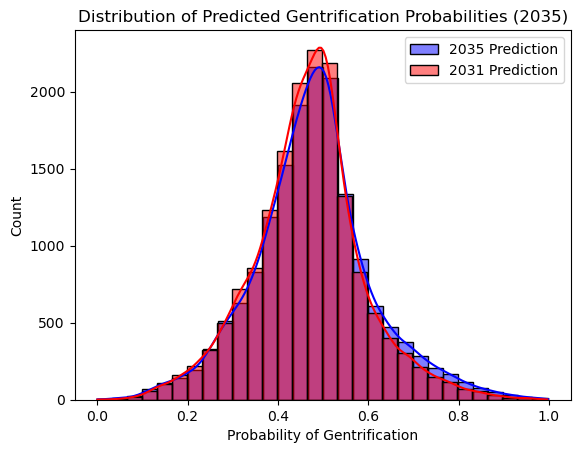

In [ ]:
import seaborn as sns

# Plot the distribution of predicted gentrification probabilities for 2035
sns.histplot(
    df_combined['gentrification_prob_2035'], 
    bins=30, 
    alpha=0.5, 
    label='2035 Prediction', 
    color='blue', 
    kde=True  # Overlay kernel density estimate for smoothness
)

# Plot the distribution of predicted gentrification probabilities for 2031
sns.histplot(
    df_combined['gentrification_prob_2031'], 
    bins=30, 
    alpha=0.5, 
    label='2031 Prediction', 
    color='red', 
    kde=True
)

# Set plot title and axis labels
plt.title('Distribution of Predicted Gentrification Probabilities (2035)')
plt.xlabel('Probability of Gentrification')
plt.ylabel('Count')

# Display legend to distinguish between years
plt.legend()

# Show the final plot
plt.show()


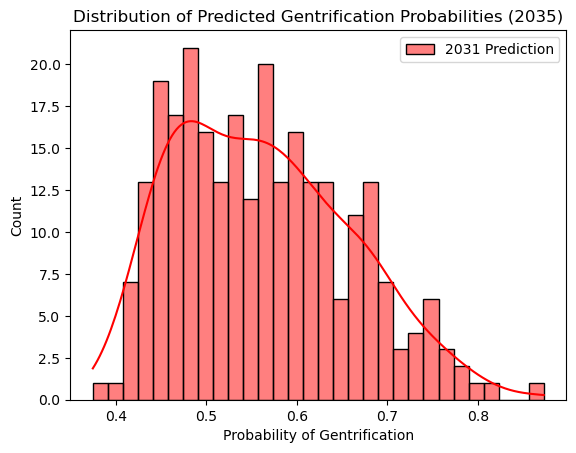

In [ ]:
import seaborn as sns

# Plot a histogram of predicted gentrification probabilities (y_probs) for 2031
sns.histplot(
    y_probs,           # Array of predicted probabilities
    bins=30,           # Number of bins in the histogram
    alpha=0.5,         # Transparency of the bars
    label='2035 Prediction',
    color='red',       # Bar color
    kde=True           # Overlay a kernel density estimate for smoother distribution
)

# Add title and axis labels for clarity
plt.title('Distribution of Predicted Gentrification Probabilities (2035)')
plt.xlabel('Probability of Gentrification')
plt.ylabel('Count')

# Add legend to distinguish the line/bar
plt.legend()

# Display the plot
plt.show()


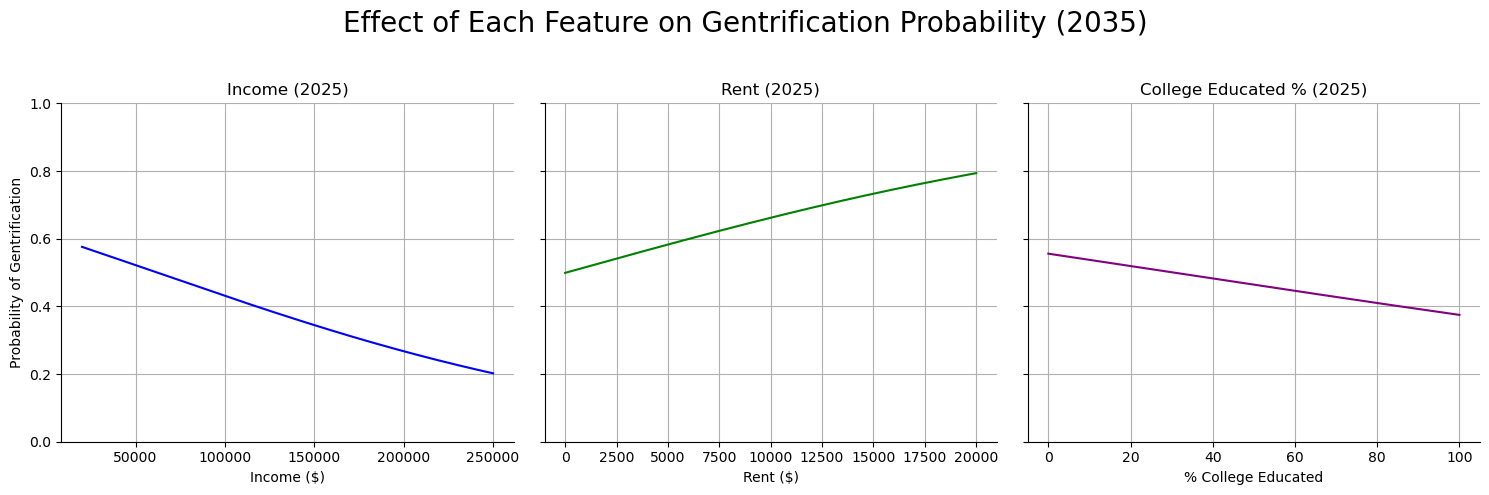

In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Assume model pipeline is trained and available ---
# pipeline.predict_proba() works

# Median values for fixed variables
income_fixed = df_test_t['income_2013'].median()
rent_fixed = df_test_t['rent_2013'].median()
college_fixed = df_test_t['college_2013'].median()

# 1. Vary income
income_range = np.linspace(20000, 250000, 500000)
X_income = pd.DataFrame({
    'income': income_range,
    'rent': rent_fixed,
    'college': college_fixed
})
probs_income = pipeline.predict_proba(X_income)[:, 1]

# 2. Vary rent
rent_range = np.linspace(0, 20000, 40000)
X_rent = pd.DataFrame({
    'income': income_fixed,
    'rent': rent_range,
    'college': college_fixed
})
probs_rent = pipeline.predict_proba(X_rent)[:, 1]

# 3. Vary college
college_range = np.linspace(0, 100, 500)
X_college = pd.DataFrame({
    'income': income_fixed,
    'rent': rent_fixed,
    'college': college_range
})
probs_college = pipeline.predict_proba(X_college)[:, 1]

# --- Create subplots ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plot income effect
axes[0].plot(income_range, probs_income, color='blue')
axes[0].set_title('Income (2025)')
axes[0].set_xlabel('Income ($)')
axes[0].set_ylabel('Probability of Gentrification')

# Plot rent effect
axes[1].plot(rent_range, probs_rent, color='green')
axes[1].set_title('Rent (2025)')
axes[1].set_xlabel('Rent ($)')

# Plot college effect
axes[2].plot(college_range, probs_college, color='purple')
axes[2].set_title('College Educated % (2025)')
axes[2].set_xlabel('% College Educated')

# Formatting
for ax in axes:
    ax.grid(True)
    ax.set_ylim(0, 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.suptitle('Effect of Each Feature on Gentrification Probability (2035)', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave room for suptitle
plt.show()


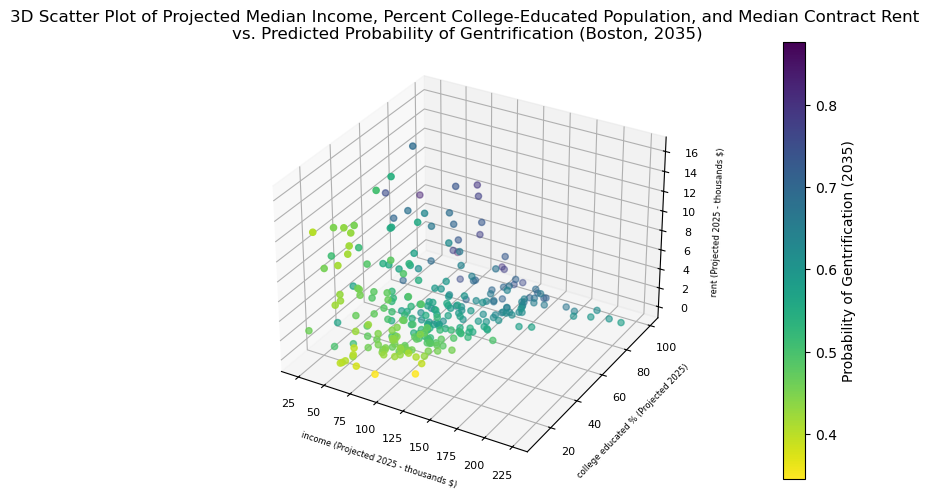

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Create a 3D figure
fig = plt.figure(plt.figure(figsize=(10, 5)))
ax = fig.add_subplot(111, projection='3d')

# Use gentrification probabilities to color the points
colors = df_test_b['gentrification_prob_2035']

# Create a 3D scatter plot of income, college %, and rent
sc = ax.scatter(
    df_test_b['income_2025'] / 1000,         # Convert income to thousands for readability
    df_test_b['college_2025'],               # Percentage of college-educated population
    df_test_b['rent_2025'] / 1000,           # Convert rent to thousands for readability
    c=colors,                                # Color intensity reflects gentrification probability
    cmap='viridis_r'                         # Reverse viridis colormap for color gradient
)

# Label axes with appropriate units and formatting
ax.set_xlabel('Income (Projected 2025 - thousands $)', fontsize=6)
ax.set_ylabel('College Educated % (Projected 2025)', fontsize=6)
ax.set_zlabel('Rent (Projected 2025 - thousands $)', fontsize=6)

# Title for the 3D plot
ax.set_title(
    '3D Scatter Plot of Projected Median Income, Percent College-Educated Population, and Median Contract Rent\n'
    'vs. Predicted Probability of Gentrification (Boston, 2035)', 
    pad=1
)

# Adjust tick size for better readability
ax.tick_params(axis='both', labelsize=8)

# Add a color bar to interpret the color mapping
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Probability of Gentrification (2035)')

# Fit layout within the figure window
plt.tight_layout()
plt.show()


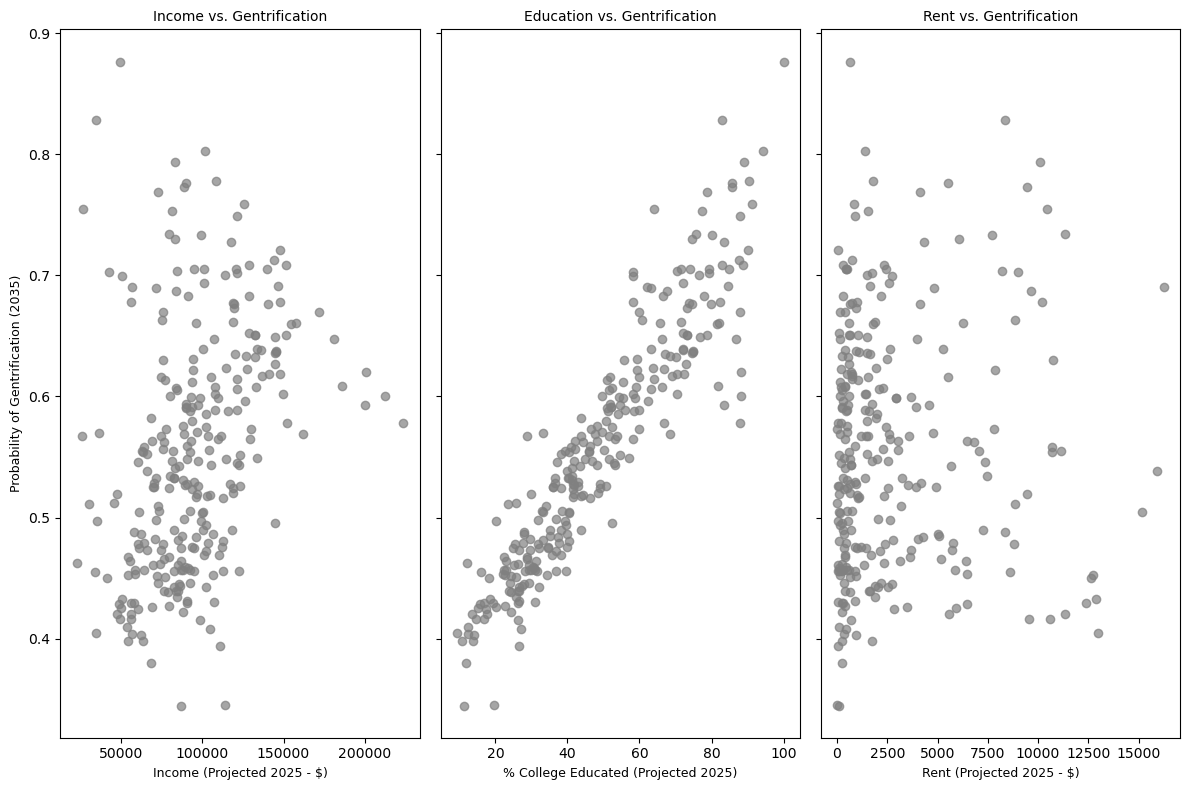

In [ ]:
# Create a figure with 3 side-by-side scatter plots, sharing the y-axis for easy comparison
fig, axes = plt.subplots(1, 3, figsize=(12, 8), sharey=True)

# Extract predicted gentrification probabilities for 2035
probs = df_test_b['gentrification_prob_2035']

# Plot Income vs. Gentrification Probability
axes[0].scatter(df_test_b['income_2025'], probs, color='grey', alpha=0.7)  # Scatter plot with semi-transparent grey dots
axes[0].set_xlabel('Income (Projected 2025 - $)', fontsize=9)               # Label x-axis
axes[0].set_ylabel('Probability of Gentrification (2035)', fontsize=9)      # Label y-axis
axes[0].set_title('Income vs. Gentrification', fontsize=10)                 # Title for the subplot

# Plot Percent College Educated vs. Gentrification Probability
axes[1].scatter(df_test_b['college_2025'], probs, color='grey', alpha=0.7) # Scatter plot for education
axes[1].set_xlabel('% College Educated (Projected 2025)', fontsize=9)       # Label x-axis
axes[1].set_title('Education vs. Gentrification', fontsize=10)              # Title for subplot

# Plot Rent vs. Gentrification Probability
axes[2].scatter(df_test_b['rent_2025'], probs, color='grey', alpha=0.7)    # Scatter plot for rent
axes[2].set_xlabel('Rent (Projected 2025 - $)', fontsize=9)                 # Label x-axis
axes[2].set_title('Rent vs. Gentrification', fontsize=10)                   # Title for subplot

# # Optional colorbar code (commented out)
# # If you wanted to use color to encode values, uncomment below
# # sc = axes[2].scatter(df_test_b['rent_2025'], colors, c=colors, cmap=cmap)
# # cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), pad=0.01)
# # cbar.set_label('Probability of Gentrification (2035)')

# Adjust spacing and layout so labels/titles don’t overlap
plt.tight_layout()

# Show the plots
plt.show()


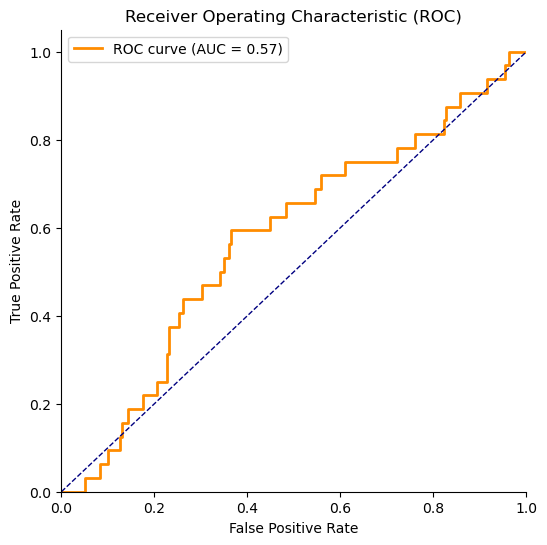

In [ ]:
# Create a square figure and axis for plotting ROC curve
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the ROC curve using false positive rate (fpr) and true positive rate (tpr)
# Color it dark orange, set line width, and add AUC score in the label
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')

# Plot the diagonal line representing a random classifier (baseline)
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

# Set limits for x and y axes from 0 to 1 (y-axis a bit above 1 for padding)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

# Label the x-axis and y-axis
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# Add title for the plot
ax.set_title('Receiver Operating Characteristic (ROC)')

# Display the legend in the upper left corner
ax.legend(loc="upper left")

# Remove the top and right borders for a cleaner look
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Show the finalized plot
plt.show()
